In [2]:
from os import getcwd
from os.path import dirname
import torch
from torch.distributions import multivariate_normal
from torch.distributions import uniform

from algorithm_package.algorithm_package import paper_algorithm
#from energy_package.energy_package import two_param
from energy_package.energy_package import XY
from energy_package.energy_package import particle_pairwise_interaction
from rf_package.rf_package import planar_flow
#from plot_animation_package.plot_animation_package import density_2D
#from plot_animation_package.plot_animation_package import XYd2n2
#from plot_animation_package.plot_animation_package import XYd2n1
from plot_animation_package.plot_animation_package import XYd2n3
from plot_animation_package.plot_animation_package import particle_pairwise_interaction_plot


In [3]:
import torch
from torch.distributions.uniform import Uniform

class MultivariateUniform(Uniform):
    def __init__(self, low, high, data_dim):
        super(MultivariateUniform, self).__init__(low, high)
        self.data_dim = data_dim

    def sample(self):
        return super().sample(torch.Size([self.data_dim]))

    def log_prob(self, value):
        if value.dim() < 1 or value.size(-1) != self.data_dim:
            raise ValueError("Last dimension of value must be of size data_dim")

        # Calculate log_prob for each dimension and sum them
        log_prob_per_dim = super().log_prob(value)
        return log_prob_per_dim.sum(-1)

import torch
from torch.autograd import grad

# Create a MultivariateUniform distribution instance
data_dim = 3
low = torch.tensor(0.0, requires_grad=True)
high = torch.tensor(1.0, requires_grad=True)
uniform_dist = MultivariateUniform(low, high, data_dim)

# Generate a sample
sample = uniform_dist.sample()

# Compute log probability
log_prob = uniform_dist.log_prob(sample)

# Calculate gradients
gradient_low = grad(log_prob, low, retain_graph=True)[0]
gradient_high = grad(log_prob, high)[0]

print("Sample:", sample)
print("Log Probability:", log_prob)
print("Gradient with respect to low:", gradient_low)
print("Gradient with respect to high:", gradient_high)


Sample: tensor([0.1860, 0.8548, 0.8278])
Log Probability: tensor(0., grad_fn=<SumBackward1>)
Gradient with respect to low: tensor(3.)
Gradient with respect to high: tensor(-3.)


In [7]:
# MODEL PARAMETERS
N = 20 #number of particles
dimensions = 2 #dimensions of the model space
data_dim = N**3 #size of the parameter space
beta = 1
#U = two_param.bistable_circle
#BC = two_param.bistable_circle_BC
#U = particle_pairwise_interaction.U
#BC = particle_pairwise_interaction.BC

U = XY.XYd2n3
BC = XY.XYd2n3_BC

energy_parameters = [1,1,1,1]

# SAVING PARAMETER
model_name = 'XYd2n3-multivariate_normal-LayeredPlanarFlow-beta1'
model_file = getcwd()+"\\saved_models"+"\\"+model_name+"\\"+model_name

# RF PARAMETERS
n = 1 #number of initial samples

#base_distribution = MultivariateUniform(0, L, data_dim)
base_distribution = multivariate_normal.MultivariateNormal(loc=torch.ones(data_dim), covariance_matrix=torch.eye(data_dim))
normalization_flow = planar_flow.LayeredPlanarFlow(data_dim)
epsilon = 1e-2 #gradient descent rate for RF parameters

# MALA PARAMETERS
time_step = 1e-1
k_lang = 10

# INITIALISATION
initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*2*torch.pi
k_max = 100

# RUN
RF_MCMC_parameters = [time_step, k_max, k_lang, epsilon]
history, array_of_model_configurations = paper_algorithm.NF_MCMC_algorithm(model_name, beta, U, BC, energy_parameters, normalization_flow, initial_data, base_distribution, *RF_MCMC_parameters)

100%|██████████| 99/99 [00:07<00:00, 13.36it/s]


In [10]:
model_name = 'XYd2n3-multivariate_normal-LayeredPlanarFlow-beta1'
model_file = getcwd()+"\\saved_models"+"\\"+model_name+"\\"+model_name

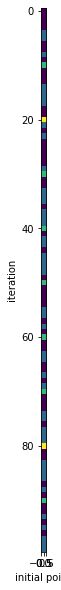

In [11]:
import matplotlib.pyplot as plt
path = dirname(model_file)
history = torch.load(path + '\\history.pt').detach()

fig, ax = plt.subplots(figsize = (5,10))
ax.imshow(history)
ax.set_xlabel('initial point')
ax.set_ylabel('iteration')
fig.savefig(path + '\\history.png')

{'beta': 1.0, 'n': 1, 'N': 8000, 'time_step': 0.1, 'k_max': 100, 'k_lang': 10, 'epsilon': 0.01, 'energy_parameters': [1.0, 1.0, 1.0, 1.0]}


MovieWriter imagemagick unavailable; using Pillow instead.


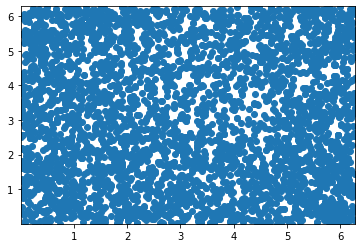

In [12]:
model_name = 'XYd2n3-multivariate_normal-LayeredPlanarFlow-beta1'
model_file = getcwd()+"\\saved_models"+"\\"+model_name+"\\"+model_name
trajectory_id = 0
path = dirname(model_file)
history = torch.load(path + '\\history.pt').detach()
particle_pairwise_interaction_plot.animation(model_file, trajectory_id, history)